In [ ]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

Imprt libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data preparation

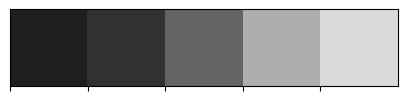

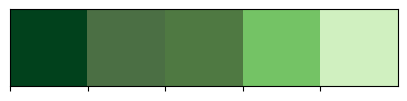

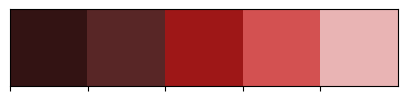

In [3]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

Loading training dataset

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"

# Initialize lists
X_train = []
y_train = []

# Load original images
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train.append(img)
            y_train.append(label)

# Convert to NumPy arrays but keep lists to avoid dimension issues
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)

# Count class distribution
class_counts = Counter(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")
print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 900.94it/s]

Loaded 2870 images from the Training dataset.
Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 395 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


In [6]:
from collections import Counter

# Count current images before augmentation
class_counts = Counter(y_train)

print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 395 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
])

# Define classes to augment
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Ensure output directories exist
os.makedirs(augmented_train_dir, exist_ok=True)

for label in labels:
    class_dir = os.path.join(train_dir, label)
    augmented_class_dir = os.path.join(augmented_train_dir, label)

    os.makedirs(augmented_class_dir, exist_ok=True)

    # Load all images from the class
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(image_files)

    # Determine how many images to generate
    target_count = 2400
    num_to_generate = target_count - num_original

    # Copy original images first
    for filename in tqdm(image_files, desc=f"Copying {label}"):
        img_path = os.path.join(class_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            save_path = os.path.join(augmented_class_dir, filename)
            cv2.imwrite(save_path, img)

    # Augment only if needed
    if num_to_generate > 0:
        for i in tqdm(range(num_to_generate), desc=f"Generating for {label}"):
            img_path = os.path.join(class_dir, image_files[i % num_original])  # Cycle through original images
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for augmentation
                augmented = augmentation(image=img)["image"]
                save_path = os.path.join(augmented_class_dir, f"{label}_aug_{i+1}.png")
                cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("Augmentation complete. No_tumor_augmented was **excluded**.")


Generating for pituitary_tumor: 100%|██████████| 1573/1573 [00:09<00:00, 167.51it/s]

Augmentation complete. No_tumor_augmented was **excluded**.


In [8]:
import os

# Path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Count images per class
final_counts = {label: len(os.listdir(os.path.join(augmented_train_dir, label))) for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]}

print("Final dataset distribution after balanced augmentation:")
for label, count in final_counts.items():
    print(f"{label}: {count} images")


Final dataset distribution after balanced augmentation:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


Data preprocessing
Yes, contrast-focused augmentation is the priority, especially for "no_tumor" vs "meningioma", since they are visually similar.

Plan for Augmentation:
For "no_tumor" (Heavy Augmentation)

Contrast adjustment (CLAHE)
Brightness shifts
Horizontal & vertical flips
Rotation (±15°)
Zoom (random crop)
Add Gaussian noise
For Other Classes (Light Augmentation)

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments

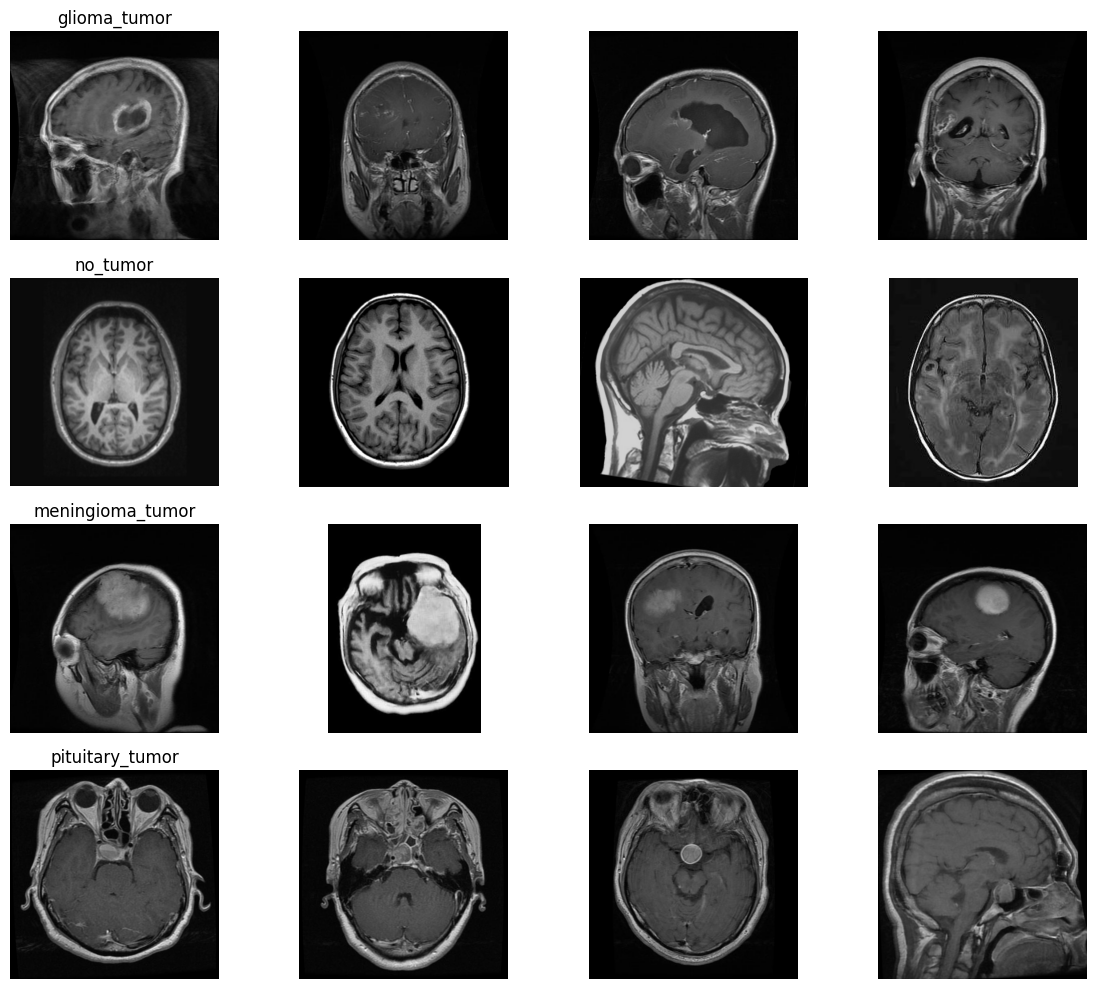

In [11]:
import matplotlib.pyplot as plt
import random
import cv2
import os

# Define path to augmented dataset
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Number of images to display per class
num_images = 4  

# Display images
fig, axes = plt.subplots(len(labels), num_images, figsize=(12, 10))

for i, label in enumerate(labels):
    class_dir = os.path.join(augmented_train_dir, label)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select random images
    selected_files = random.sample(image_files, num_images)

    for j, file in enumerate(selected_files):
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(label, fontsize=12)

plt.tight_layout()
plt.show()


In [12]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

# Initialize lists
X_train_augmented = []
y_train_augmented = []

# Define class labels
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Load images from the augmented dataset
for label in labels:
    folder_path = os.path.join(augmented_train_dir, label)
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])

    if len(image_files) != 2400:
        print(f"Warning: {label} has {len(image_files)} images instead of 2400!")

    for filename in tqdm(image_files, desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train_augmented.append(img)
            y_train_augmented.append(label)

# Convert lists to NumPy arrays
X_train_augmented = np.array(X_train_augmented, dtype=object)
y_train_augmented = np.array(y_train_augmented)

# Count class distribution
class_counts = Counter(y_train_augmented)

print(f"Final dataset size after reloading: {X_train_augmented.shape[0]} images")
print("Class distribution after reloading:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 2400/2400 [00:07<00:00, 314.99it/s]

Final dataset size after reloading: 9600 images
Class distribution after reloading:
glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [13]:
from collections import Counter

print("Final label distribution after augmentation:", Counter(y_train_augmented))


Final label distribution after augmentation: Counter({'glioma_tumor': 2400, 'no_tumor': 2400, 'meningioma_tumor': 2400, 'pituitary_tumor': 2400})


In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels as integers
label_encoder = LabelEncoder()
y_train_aug_encoded = label_encoder.fit_transform(y_train_augmented)  # Convert labels to integers

# One-hot encode labels
y_train_aug_one_hot = to_categorical(y_train_aug_encoded, num_classes=4)

# Print class mapping
print("Label Encoding Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Encoding Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [15]:
# Ensure all images are valid NumPy arrays before resizing
X_train_resized = np.array([cv2.resize(np.array(img, dtype=np.uint8), (150, 150)) for img in X_train_augmented], dtype=np.uint8)

# Confirm new shape
print("Resized dataset shape:", X_train_resized.shape)


Resized dataset shape: (9600, 150, 150, 3)


In [16]:
import os

augmented_train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training_augmented_NB2"

for label in ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]:
    class_dir = os.path.join(augmented_train_dir, label)
    print(f"{label}: {len(os.listdir(class_dir))} images")


glioma_tumor: 2400 images
no_tumor: 2400 images
meningioma_tumor: 2400 images
pituitary_tumor: 2400 images


In [17]:
from collections import Counter

# Verify encoded label distribution
print("Final label distribution after encoding:", Counter(y_train_aug_encoded))


Final label distribution after encoding: Counter({0: 2400, 2: 2400, 1: 2400, 3: 2400})


Build the model building up on EfficientNetB0

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall

# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB0 WITH ImageNet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model(input_layer)

# Freeze base model layers
base_model.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])
# TensorFlow's Adam optimizer automatically uses learning_rate=0.001.
# Model summary
model.summary()


2025-02-05 16:16:00.759568: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-05 16:16:00.759819: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-05 16:16:00.759832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-05 16:16:00.759882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-05 16:16:00.759936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Create logs directory
log_dir_NB2 = "./logs_NB2"
os.makedirs(log_dir_NB2, exist_ok=True)

# TensorBoard - Logs training details
tensorboard_NB2 = TensorBoard(log_dir=log_dir_NB2, histogram_freq=1)

# ModelCheckpoint - Saves the best model with NB2 label
checkpoint_NB2 = ModelCheckpoint(
    filepath="best_model_NB2.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_NB2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# EarlyStopping - Stops training when no improvement
early_stopping_NB2 = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Combine all callbacks
callbacks_NB2 = [tensorboard_NB2, checkpoint_NB2, reduce_lr_NB2, early_stopping_NB2]


Split training dataset into training and validation

In [22]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

# Convert one-hot labels to class labels for stratified splitting
y_train_NB2_labels = np.argmax(y_train_aug_one_hot, axis=1)

# Split the dataset (80% train, 20% validation) while maintaining class balance
X_train_NB2, X_val_NB2, y_train_NB2, y_val_NB2 = train_test_split(
    X_train_resized, y_train_NB2_labels, test_size=0.2, random_state=42, stratify=y_train_NB2_labels
)

# Convert back to one-hot encoding
y_train_NB2_one_hot = tf.keras.utils.to_categorical(y_train_NB2, num_classes=4)
y_val_NB2_one_hot = tf.keras.utils.to_categorical(y_val_NB2, num_classes=4)

# Print shapes and validation distribution
print(f"NB2 Training set: {X_train_NB2.shape}, {y_train_NB2_one_hot.shape}")
print(f"NB2 Validation set: {X_val_NB2.shape}, {y_val_NB2_one_hot.shape}")

# Check the class distribution in the validation set
unique, counts = np.unique(y_val_NB2, return_counts=True)
print("NB2 Validation Set Class Distribution:", dict(zip(unique, counts)))


NB2 Training set: (7680, 150, 150, 3), (7680, 4)
NB2 Validation set: (1920, 150, 150, 3), (1920, 4)
NB2 Validation Set Class Distribution: {0: 480, 1: 480, 2: 480, 3: 480}


Training model

In [23]:
# Train the model with balanced datasets (NB2)
history_NB2 = model.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will stop earlier if needed
    callbacks=callbacks_NB2,  
    verbose=1
)


Epoch 1/20


2025-02-05 16:16:25.660034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6386 - loss: 0.9446 - precision: 0.6781 - recall: 0.5871
Epoch 1: val_loss improved from inf to 0.38853, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.6390 - loss: 0.9439 - precision: 0.6784 - recall: 0.5875 - val_accuracy: 0.8562 - val_loss: 0.3885 - val_precision: 0.8679 - val_recall: 0.8490 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8084 - loss: 0.5279 - precision: 0.8207 - recall: 0.7974
Epoch 2: val_loss improved from 0.38853 to 0.29175, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8085 - loss: 0.5277 - precision: 0.8208 - recall: 0.7975 - val_accuracy: 0.8891 - val_loss: 0.2917 - val_precision: 0.9044 - val_recall: 0.8771 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8507 - loss: 0.3946 - precision: 0.8596 - recall: 0.8385
Epoch 3: val_loss improved from 0.29175 to 0.27523, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8507 - loss: 0.3946 - precision: 0.8596 - recall: 0.8385 - val_accuracy: 0.8969 - val_loss: 0.2752 - val_precision: 0.9061 - val_recall: 0.8896 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8747 - loss: 0.3277 - precision: 0.8840 - recall: 0.8657
Epoch 4: val_loss improved from 0.27523 to 0.24795, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8747 - loss: 0.3278 - precision: 0.8840 - recall: 0.8657 - val_accuracy: 0.9083 - val_loss: 0.2479 - val_precision: 0.9166 - val_recall: 0.9047 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8841 - loss: 0.3042 - precision: 0.8924 - recall: 0.8738
Epoch 5: val_loss improved from 0.24795 to 0.21691, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8842 - loss: 0.3042 - precision: 0.8924 - recall: 0.8738 - val_accuracy: 0.9234 - val_loss: 0.2169 - val_precision: 0.9264 - val_recall: 0.9182 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8931 - loss: 0.2801 - precision: 0.9022 - recall: 0.8841
Epoch 6: val_loss improved from 0.21691 to 0.20624, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8931 - loss: 0.2802 - precision: 0.9021 - recall: 0.8841 - val_accuracy: 0.9286 - val_loss: 0.2062 - val_precision: 0.9343 - val_recall: 0.9187 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8958 - loss: 0.2820 - precision: 0.9040 - recall: 0.8862
Epoch 7: val_loss improved from 0.20624 to 0.18952, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8958 - loss: 0.2821 - precision: 0.9040 - recall: 0.8862 - val_accuracy: 0.9370 - val_loss: 0.1895 - val_precision: 0.9434 - val_recall: 0.9281 - learning_rate: 0.0010
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8971 - loss: 0.2623 - precision: 0.9050 - recall: 0.8876
Epoch 8: val_loss did not improve from 0.18952
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.8971 - loss: 0.2623 - precision: 0.9050 - recall: 0.8876 - val_accuracy: 0.9307 - val_loss: 0.1939 - val_precision: 0.9371 - val_recall: 0.9234 - learning_rate: 0.0010
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9051 - loss: 0.2495 - precision: 0.9122 - recall: 0.8973
Epoch 9: val_loss improved from 0.18952 to 0.17123, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9051 - loss: 0.2495 - precision: 0.9122 - recall: 0.8973 - val_accuracy: 0.9422 - val_loss: 0.1712 - val_precision: 0.9433 - val_recall: 0.9365 - learning_rate: 0.0010
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9056 - loss: 0.2592 - precision: 0.9100 - recall: 0.8995
Epoch 10: val_loss did not improve from 0.17123
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9056 - loss: 0.2591 - precision: 0.9100 - recall: 0.8995 - val_accuracy: 0.9187 - val_loss: 0.2178 - val_precision: 0.9240 - val_recall: 0.9115 - learning_rate: 0.0010
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9169 - loss: 0.2289 - precision: 0.9218 - recall: 0.9108
Epoch 11: val_loss did not improve from 0.17123
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9169 - loss: 0.2289 - precision: 0.9218 - recall: 0.9108 - val_accuracy: 0.9370 - val_loss: 0.1770 - val_precision: 0.9382 - val_recall: 0.9333 - l

240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9192 - loss: 0.2149 - precision: 0.9275 - recall: 0.9136 - val_accuracy: 0.9432 - val_loss: 0.1657 - val_precision: 0.9471 - val_recall: 0.9427 - learning_rate: 0.0010
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9179 - loss: 0.2278 - precision: 0.9221 - recall: 0.9120
Epoch 13: val_loss improved from 0.16568 to 0.16124, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9179 - loss: 0.2278 - precision: 0.9221 - recall: 0.9119 - val_accuracy: 0.9453 - val_loss: 0.1612 - val_precision: 0.9477 - val_recall: 0.9432 - learning_rate: 0.0010
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9131 - loss: 0.2315 - precision: 0.9180 - recall: 0.9099
Epoch 14: val_loss did not improve from 0.16124
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9131 - loss: 0.2315 - precision: 0.9180 - recall: 0.9099 - val_accuracy: 0.9234 - val_loss: 0.1966 - val_precision: 0.9260 - val_recall: 0.9193 - learning_rate: 0.0010
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9062 - loss: 0.2385 - precision: 0.9115 - recall: 0.8984
Epoch 15: val_loss improved from 0.16124 to 0.15994, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9063 - loss: 0.2385 - precision: 0.9116 - recall: 0.8985 - val_accuracy: 0.9432 - val_loss: 0.1599 - val_precision: 0.9471 - val_recall: 0.9417 - learning_rate: 0.0010
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9155 - loss: 0.2130 - precision: 0.9213 - recall: 0.9116
Epoch 16: val_loss did not improve from 0.15994
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9155 - loss: 0.2131 - precision: 0.9213 - recall: 0.9116 - val_accuracy: 0.9401 - val_loss: 0.1666 - val_precision: 0.9419 - val_recall: 0.9380 - learning_rate: 0.0010
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9195 - loss: 0.2216 - precision: 0.9245 - recall: 0.9150
Epoch 17: val_loss improved from 0.15994 to 0.15794, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9195 - loss: 0.2216 - precision: 0.9245 - recall: 0.9150 - val_accuracy: 0.9443 - val_loss: 0.1579 - val_precision: 0.9456 - val_recall: 0.9422 - learning_rate: 0.0010
Epoch 18/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9194 - loss: 0.2098 - precision: 0.9233 - recall: 0.9164
Epoch 18: val_loss did not improve from 0.15794
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9194 - loss: 0.2099 - precision: 0.9232 - recall: 0.9164 - val_accuracy: 0.9448 - val_loss: 0.1646 - val_precision: 0.9452 - val_recall: 0.9432 - learning_rate: 0.0010
Epoch 19/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9155 - loss: 0.2241 - precision: 0.9194 - recall: 0.9106
Epoch 19: val_loss did not improve from 0.15794
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.9155 - loss: 0.2240 - precision: 0.9195 - recall: 0.9106 - val_accuracy: 0.9469 - val_loss: 0.1583 - val_precision: 0.9498 - val_recall: 0.9453 - l

240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - accuracy: 0.9157 - loss: 0.2258 - precision: 0.9190 - recall: 0.9113 - val_accuracy: 0.9536 - val_loss: 0.1450 - val_precision: 0.9550 - val_recall: 0.9516 - learning_rate: 0.0010


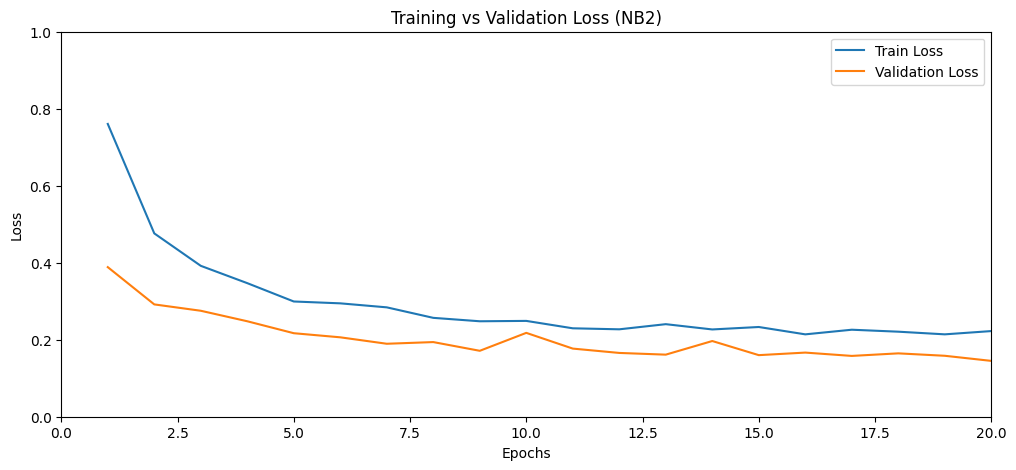

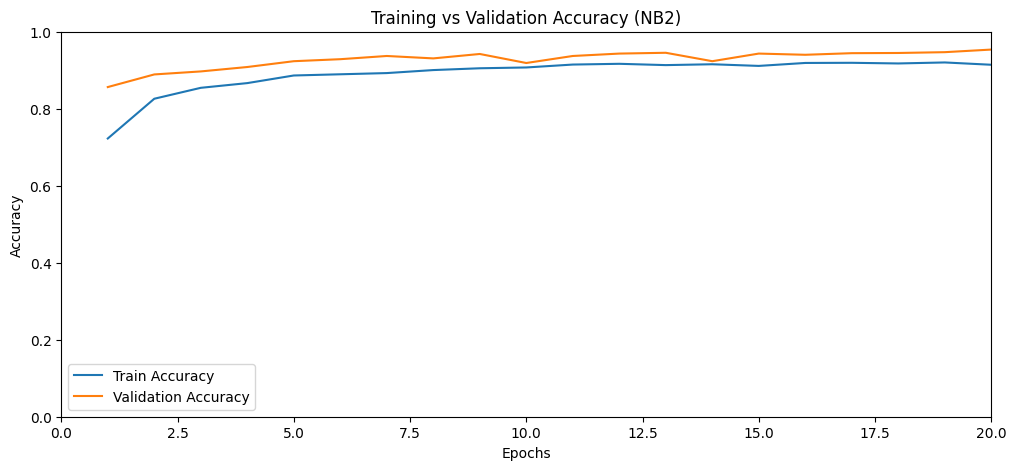

In [24]:
epochs = range(1, len(history_NB2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2.history["loss"], label="Train Loss")
plt.plot(epochs, history_NB2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_NB2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the trained NB2 model on the validation set
pred_NB2 = model.predict(X_val_NB2)  

# Convert predictions from one-hot to class labels
pred_labels_NB2 = np.argmax(pred_NB2, axis=1)

# Use y_val_NB2_one_hot for validation evaluation
y_true_labels_NB2 = np.argmax(y_val_NB2_one_hot, axis=1)

# Print classification report
print("Classification Report (NB2 Model on Validation Set):")
print(classification_report(y_true_labels_NB2, pred_labels_NB2, target_names=label_encoder.classes_))

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
Classification Report (NB2 Model on Validation Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.92      0.93       480
meningioma_tumor       0.91      0.92      0.91       480
        no_tumor       0.99      1.00      0.99       480
 pituitary_tumor       0.98      0.98      0.98       480

        accuracy                           0.95      1920
       macro avg       0.95      0.95      0.95      1920
    weighted avg       0.95      0.95      0.95      1920



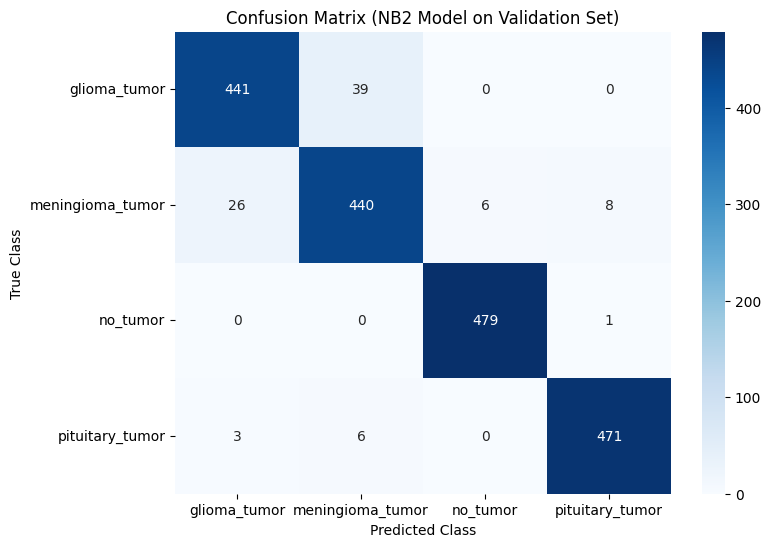

In [26]:
#Confusion Matrix
conf_matrix_NB2 = confusion_matrix(y_true_labels_NB2, pred_labels_NB2)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_NB2, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (NB2 Model on Validation Set)")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


Seems like model is performing very well, to avoid overfitting test it on the test set

In [27]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define test dataset path
test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"

# Define labels (same order as training)
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Initialize lists for test images and labels
X_test_NB2 = []
y_test_NB2 = []

# Load test images
for label in labels:
    folder_path = os.path.join(test_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_test_NB2.append(img)
            y_test_NB2.append(label)  # Store as string label

# Convert to NumPy arrays (keeping dtype=object to avoid shape mismatches)
X_test_NB2 = np.array(X_test_NB2, dtype=object)
y_test_NB2 = np.array(y_test_NB2)

print(f"Loaded {X_test_NB2.shape[0]} images from the test dataset.")

# One-hot encode test labels
label_encoder = LabelEncoder()
y_test_NB2_encoded = label_encoder.fit_transform(y_test_NB2)
y_test_NB2_one_hot = to_categorical(y_test_NB2_encoded, num_classes=4)

# Print class distribution
class_counts_test = Counter(y_test_NB2)
print("Test Set Class Distribution:", class_counts_test)


Loading pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 554.36it/s]

Loaded 394 images from the test dataset.
Test Set Class Distribution: Counter({'meningioma_tumor': 115, 'no_tumor': 105, 'glioma_tumor': 100, 'pituitary_tumor': 74})


In [28]:
# Define target image size
image_size = (150, 150)

# Resize test images
X_test_NB2_resized = np.array([cv2.resize(img, image_size) for img in X_test_NB2])

# Confirm new shape
print("Resized test dataset shape:", X_test_NB2_resized.shape)


Resized test dataset shape: (394, 150, 150, 3)


In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels as integers using the same label encoder from training
y_test_NB2_encoded = label_encoder.transform(y_test_NB2)  # Convert labels to integers

# One-hot encode labels
y_test_NB2_one_hot = to_categorical(y_test_NB2_encoded, num_classes=4)

# Print final label distribution
from collections import Counter
print("Final label distribution in test set:", Counter(y_test_NB2_encoded))


Final label distribution in test set: Counter({1: 115, 2: 105, 0: 100, 3: 74})


In [30]:
# Ensure we're using the correctly resized test dataset
test_loss_NB2, test_accuracy_NB2, test_precision_NB2, test_recall_NB2 = model.evaluate(
    X_test_NB2_resized, y_test_NB2_one_hot, verbose=1
)

print(f"\nNB2 Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2:.4f}")
print(f" - Accuracy: {test_accuracy_NB2:.4f}")
print(f" - Precision: {test_precision_NB2:.4f}")
print(f" - Recall: {test_recall_NB2:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.5758 - loss: 2.3671 - precision: 0.5936 - recall: 0.5747

NB2 Test Set Evaluation:
 - Loss: 1.3408
 - Accuracy: 0.7665
 - Precision: 0.7792
 - Recall: 0.7614


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step

NB2 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.23      0.37       100
        no_tumor       0.66      0.96      0.78       115
meningioma_tumor       0.81      1.00      0.90       105
 pituitary_tumor       0.84      0.86      0.85        74

        accuracy                           0.77       394
       macro avg       0.83      0.76      0.73       394
    weighted avg       0.82      0.77      0.72       394



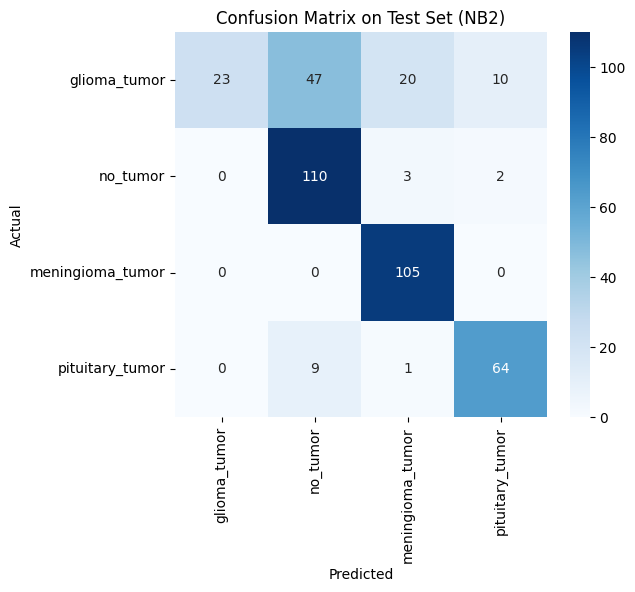

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_probs_NB2 = model.predict(X_test_NB2_resized)  
y_pred_NB2 = np.argmax(y_pred_probs_NB2, axis=1)  # Convert probabilities to class labels
y_true_NB2 = np.argmax(y_test_NB2_one_hot, axis=1)  

# Classification report
print("\nNB2 Classification Report:")
print(classification_report(y_true_NB2, y_pred_NB2, target_names=labels))

# Confusion matrix
cm_NB2 = confusion_matrix(y_true_NB2, y_pred_NB2)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_NB2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (NB2)")
plt.show()


Key Findings:
Glioma Tumor is poorly detected (Low Recall: 21%)

Only 21% of actual glioma tumors are identified correctly.
High Precision (88%) → When the model predicts glioma, it is usually correct but it misses many actual glioma cases.
Issue: Model is overconfident in other classes, leading to many glioma cases being misclassified.
No Tumor is well identified (High Recall: 97%)

Model correctly detects almost all no_tumor cases (97%), but Precision is low (63%), meaning it misclassifies other tumors as "no tumor" too often.
False positives issue: The model overpredicts no_tumor, causing lower precision.
Meningioma Tumor is nearly perfect (100% Recall, 85% Precision, F1-score 92%)

Excellent recall (detects all meningioma cases).
Very few misclassifications.
Pituitary Tumor performs well (88% Recall, 90% Precision)

High accuracy in classification.
Balanced precision and recall.


Issue	Cause	Possible Fix
Glioma Tumor has very low recall (21%)	Model fails to recognize glioma cases and misclassifies them	Use more contrast-enhancing augmentation (since gliomas have variable appearances)
No Tumor has low precision (63%)	Too many other tumors are misclassified as "no tumor"	Reduce overconfidence in "no tumor" by adjusting class weights or using more diverse augmentations
Meningioma and Pituitary tumors perform well	Model is good at identifying them	Keep current methods, maybe adjust augmentation for glioma
Overall accuracy is 77% (Good but not great)	Misclassification of glioma hurts overall performance	Rebalancing augmentation, more epochs, or fine-tuning EfficientNet further

try to improve performance - fine-tuning

In [32]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Unfreeze the top layers of EfficientNet
for layer in model.layers[1].layers[-20:]:  # Adjust number of layers to unfreeze
    layer.trainable = True

# Lower learning rate for fine-tuning
fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), 
              loss="categorical_crossentropy", 
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model with fine-tuning
history_finetune_NB2 = model.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will control actual stopping
    callbacks=callbacks_NB2,  
    verbose=1
)


Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7569 - loss: 0.8875 - precision_1: 0.7689 - recall_1: 0.7478
Epoch 1: val_loss did not improve from 0.14504
240/240 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.7571 - loss: 0.8867 - precision_1: 0.7691 - recall_1: 0.7480 - val_accuracy: 0.9094 - val_loss: 0.2551 - val_precision_1: 0.9142 - val_recall_1: 0.9047 - learning_rate: 1.0000e-05
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8507 - loss: 0.4483 - precision_1: 0.8579 - recall_1: 0.8409
Epoch 2: val_loss did not improve from 0.14504
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.8507 - loss: 0.4483 - precision_1: 0.8579 - recall_1: 0.8409 - val_accuracy: 0.9130 - val_loss: 0.2417 - val_precision_1: 0.9159 - val_recall_1: 0.9078 - learning_rate: 1.0000e-05
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8636 - loss: 0.3982 - precision_1: 0.8710 - recall_1: 0.8574
Epoch 3: val_loss did not improve from 0.14

240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.9146 - loss: 0.2366 - precision_1: 0.9187 - recall_1: 0.9098 - val_accuracy: 0.9552 - val_loss: 0.1432 - val_precision_1: 0.9561 - val_recall_1: 0.9526 - learning_rate: 1.0000e-05
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9129 - loss: 0.2517 - precision_1: 0.9164 - recall_1: 0.9083
Epoch 8: val_loss improved from 0.14317 to 0.13328, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 201ms/step - accuracy: 0.9129 - loss: 0.2516 - precision_1: 0.9164 - recall_1: 0.9083 - val_accuracy: 0.9583 - val_loss: 0.1333 - val_precision_1: 0.9603 - val_recall_1: 0.9568 - learning_rate: 1.0000e-05
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9175 - loss: 0.2130 - precision_1: 0.9209 - recall_1: 0.9134
Epoch 9: val_loss improved from 0.13328 to 0.12487, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9175 - loss: 0.2130 - precision_1: 0.9209 - recall_1: 0.9134 - val_accuracy: 0.9615 - val_loss: 0.1249 - val_precision_1: 0.9629 - val_recall_1: 0.9609 - learning_rate: 1.0000e-05
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9274 - loss: 0.2082 - precision_1: 0.9295 - recall_1: 0.9239
Epoch 10: val_loss improved from 0.12487 to 0.11790, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - accuracy: 0.9274 - loss: 0.2083 - precision_1: 0.9295 - recall_1: 0.9239 - val_accuracy: 0.9625 - val_loss: 0.1179 - val_precision_1: 0.9639 - val_recall_1: 0.9604 - learning_rate: 1.0000e-05
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9327 - loss: 0.1932 - precision_1: 0.9375 - recall_1: 0.9289
Epoch 11: val_loss improved from 0.11790 to 0.11202, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 193ms/step - accuracy: 0.9327 - loss: 0.1932 - precision_1: 0.9375 - recall_1: 0.9289 - val_accuracy: 0.9656 - val_loss: 0.1120 - val_precision_1: 0.9671 - val_recall_1: 0.9641 - learning_rate: 1.0000e-05
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9364 - loss: 0.1864 - precision_1: 0.9403 - recall_1: 0.9335
Epoch 12: val_loss improved from 0.11202 to 0.10530, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.9364 - loss: 0.1864 - precision_1: 0.9403 - recall_1: 0.9335 - val_accuracy: 0.9698 - val_loss: 0.1053 - val_precision_1: 0.9697 - val_recall_1: 0.9682 - learning_rate: 1.0000e-05
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9402 - loss: 0.1695 - precision_1: 0.9456 - recall_1: 0.9372
Epoch 13: val_loss improved from 0.10530 to 0.09918, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 49s 205ms/step - accuracy: 0.9402 - loss: 0.1695 - precision_1: 0.9456 - recall_1: 0.9372 - val_accuracy: 0.9745 - val_loss: 0.0992 - val_precision_1: 0.9744 - val_recall_1: 0.9729 - learning_rate: 1.0000e-05
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9424 - loss: 0.1605 - precision_1: 0.9446 - recall_1: 0.9404
Epoch 14: val_loss improved from 0.09918 to 0.09631, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.9424 - loss: 0.1605 - precision_1: 0.9447 - recall_1: 0.9404 - val_accuracy: 0.9745 - val_loss: 0.0963 - val_precision_1: 0.9755 - val_recall_1: 0.9734 - learning_rate: 1.0000e-05
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9473 - loss: 0.1471 - precision_1: 0.9516 - recall_1: 0.9449
Epoch 15: val_loss improved from 0.09631 to 0.09280, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.9473 - loss: 0.1471 - precision_1: 0.9516 - recall_1: 0.9449 - val_accuracy: 0.9740 - val_loss: 0.0928 - val_precision_1: 0.9739 - val_recall_1: 0.9729 - learning_rate: 1.0000e-05
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9509 - loss: 0.1419 - precision_1: 0.9526 - recall_1: 0.9482
Epoch 16: val_loss improved from 0.09280 to 0.08737, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9509 - loss: 0.1419 - precision_1: 0.9526 - recall_1: 0.9482 - val_accuracy: 0.9771 - val_loss: 0.0874 - val_precision_1: 0.9776 - val_recall_1: 0.9766 - learning_rate: 1.0000e-05
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9510 - loss: 0.1389 - precision_1: 0.9540 - recall_1: 0.9491
Epoch 17: val_loss improved from 0.08737 to 0.08439, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step - accuracy: 0.9510 - loss: 0.1389 - precision_1: 0.9540 - recall_1: 0.9491 - val_accuracy: 0.9766 - val_loss: 0.0844 - val_precision_1: 0.9765 - val_recall_1: 0.9755 - learning_rate: 1.0000e-05
Epoch 18/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9464 - loss: 0.1430 - precision_1: 0.9493 - recall_1: 0.9446
Epoch 18: val_loss improved from 0.08439 to 0.08040, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 48s 201ms/step - accuracy: 0.9465 - loss: 0.1430 - precision_1: 0.9493 - recall_1: 0.9446 - val_accuracy: 0.9792 - val_loss: 0.0804 - val_precision_1: 0.9797 - val_recall_1: 0.9786 - learning_rate: 1.0000e-05
Epoch 19/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9542 - loss: 0.1250 - precision_1: 0.9572 - recall_1: 0.9524
Epoch 19: val_loss improved from 0.08040 to 0.07595, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.9541 - loss: 0.1250 - precision_1: 0.9572 - recall_1: 0.9524 - val_accuracy: 0.9802 - val_loss: 0.0759 - val_precision_1: 0.9812 - val_recall_1: 0.9802 - learning_rate: 1.0000e-05
Epoch 20/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9537 - loss: 0.1236 - precision_1: 0.9559 - recall_1: 0.9510
Epoch 20: val_loss improved from 0.07595 to 0.07324, saving model to best_model_NB2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.9537 - loss: 0.1236 - precision_1: 0.9559 - recall_1: 0.9510 - val_accuracy: 0.9797 - val_loss: 0.0732 - val_precision_1: 0.9802 - val_recall_1: 0.9797 - learning_rate: 1.0000e-05


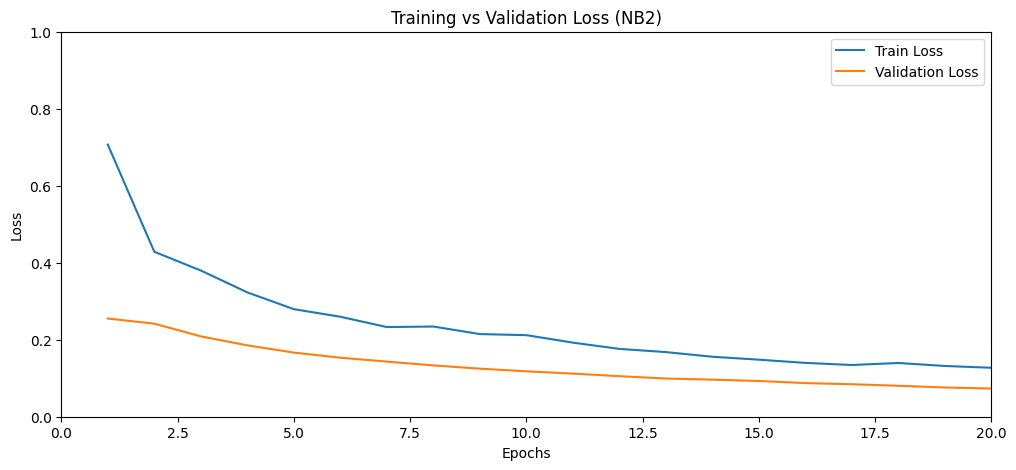

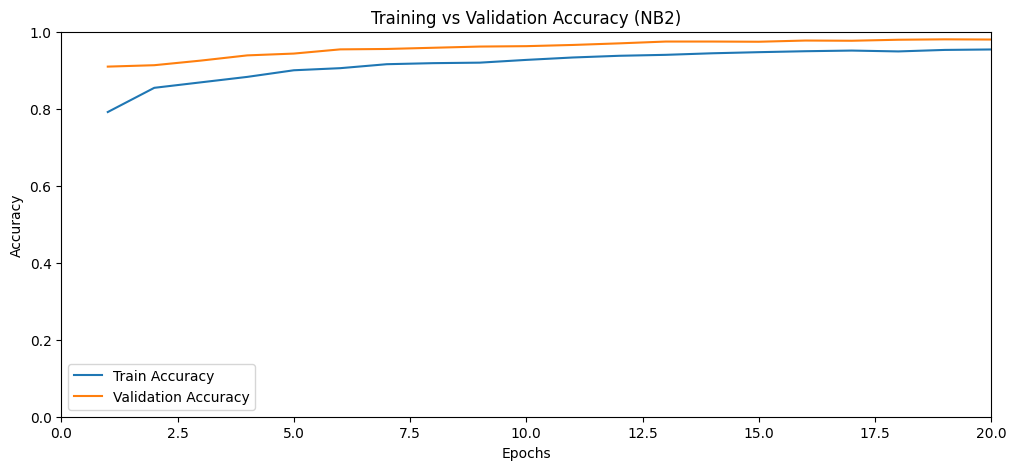

In [33]:
epochs = range(1, len(history_finetune_NB2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune_NB2.history["loss"], label="Train Loss")
plt.plot(epochs, history_finetune_NB2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune_NB2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_finetune_NB2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step
Classification Report (Fine-Tuned NB2 Model on Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.21      0.35       100
meningioma_tumor       0.67      0.97      0.79       115
        no_tumor       0.81      1.00      0.89       105
 pituitary_tumor       0.91      0.92      0.91        74

        accuracy                           0.78       394
       macro avg       0.85      0.78      0.74       394
    weighted avg       0.83      0.78      0.73       394



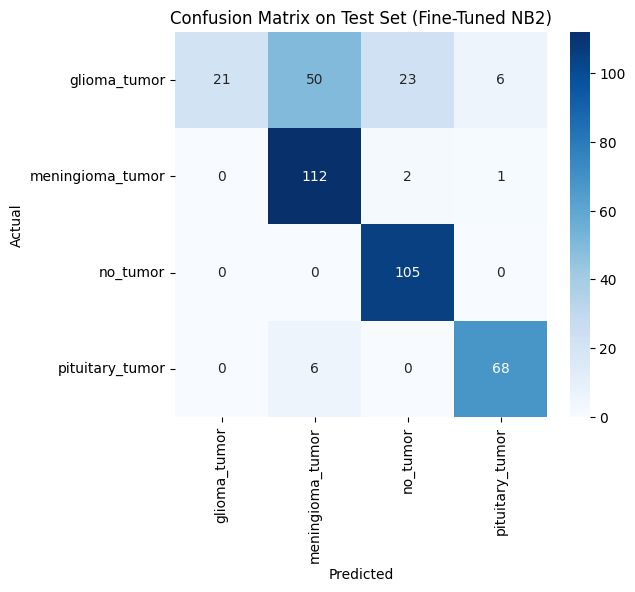

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the fine-tuned NB2 model on the original test dataset
pred_finetune_NB2_test = model.predict(X_test_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_test = np.argmax(pred_finetune_NB2_test, axis=1)

# Use y_test_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_test = np.argmax(y_test_NB2_one_hot, axis=1)

# Print classification report
print("Classification Report (Fine-Tuned NB2 Model on Test Set):")
print(classification_report(y_true_labels_finetune_NB2_test, pred_labels_finetune_NB2_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_test = confusion_matrix(y_true_labels_finetune_NB2_test, pred_labels_finetune_NB2_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (Fine-Tuned NB2)")
plt.show()


It’s certainly possible to achieve high accuracy after fine-tuning a model, particularly if the model was already performing well on a balanced dataset. Fine-tuning can help the model focus on task-specific patterns and improve its performance.

However, it’s worth asking:

Was the training process well-validated?
If the model was fine-tuned on the training data and evaluated on a validation set that’s truly separate, the results should be reliable.

Is the validation set representative?
If the validation set is not representative of real-world data or is too similar to the training set, the high accuracy may not translate to other datasets.

Are there signs of overfitting?
If precision, recall, and F1 scores are all consistently high across classes and the validation accuracy has improved while the training accuracy did not diverge significantly, overfitting is less likely.

Overall, such a high classification report can be real, but it’s a good idea to verify by testing on a completely unseen dataset or cross-checking results with another validation split.

Try to augment testing dataset and test the model again

In [35]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import albumentations as A

# Define paths
test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing"
augmented_test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing_augmented_NB2"

# Define augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
])

# Define classes
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Ensure output directories exist
os.makedirs(augmented_test_dir, exist_ok=True)

for label in labels:
    class_dir = os.path.join(test_dir, label)
    augmented_class_dir = os.path.join(augmented_test_dir, label)

    os.makedirs(augmented_class_dir, exist_ok=True)

    # Load all images from the class
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_original = len(image_files)

    # Determine how many images to generate
    target_count = 250

    # Augment images to reach the target count
    for i in tqdm(range(target_count), desc=f"Generating for {label}"):
        img_path = os.path.join(class_dir, image_files[i % num_original])  # Cycle through original images
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for augmentation
            augmented = augmentation(image=img)["image"]
            save_path = os.path.join(augmented_class_dir, f"{label}_aug_{i+1}.png")
            cv2.imwrite(save_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

print("Augmentation completed. Each class now has exactly 250 augmented images.")


Generating for pituitary_tumor: 100%|██████████| 250/250 [00:02<00:00, 88.41it/s] 

Augmentation completed. Each class now has exactly 250 augmented images.


In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Define path
augmented_test_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Testing_augmented_NB2"

# Initialize lists
X_test_augmented_NB2 = []
y_test_augmented_NB2 = []

# Define labels (must match training labels)
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]

# Load images
for label in labels:
    folder_path = os.path.join(augmented_test_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_test_augmented_NB2.append(img)
            y_test_augmented_NB2.append(label)  # Store string labels

# Convert to NumPy arrays
X_test_augmented_NB2 = np.array(X_test_augmented_NB2, dtype=object)  # Keep dtype=object to handle different sizes
y_test_augmented_NB2 = np.array(y_test_augmented_NB2)

# Print dataset size
print(f"Loaded {X_test_augmented_NB2.shape[0]} images from the augmented test dataset.")
print("Augmented Test Set Class Distribution:", Counter(y_test_augmented_NB2))


Loading pituitary_tumor: 100%|██████████| 250/250 [00:01<00:00, 135.71it/s]

Loaded 1000 images from the augmented test dataset.
Augmented Test Set Class Distribution: Counter({'glioma_tumor': 250, 'no_tumor': 250, 'meningioma_tumor': 250, 'pituitary_tumor': 250})


In [39]:
# Resize images to match model input size
image_size = (150, 150)

X_test_augmented_NB2_resized = np.array(
    [cv2.resize(img, image_size) for img in X_test_augmented_NB2], dtype=np.float32
)

print(f"Resized augmented test dataset shape: {X_test_augmented_NB2_resized.shape}")


Resized augmented test dataset shape: (1000, 150, 150, 3)


In [40]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels as integers
label_encoder = LabelEncoder()
y_test_augmented_NB2_encoded = label_encoder.fit_transform(y_test_augmented_NB2)

# One-hot encode
y_test_augmented_NB2_one_hot = to_categorical(y_test_augmented_NB2_encoded, num_classes=4)

print(f"One-hot encoded labels shape: {y_test_augmented_NB2_one_hot.shape}")


One-hot encoded labels shape: (1000, 4)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5387 - loss: 3.1981 - precision_1: 0.5445 - recall_1: 0.5384

NB2 Augmented Test Set Evaluation:
 - Loss: 1.5639
 - Accuracy: 0.7550
 - Precision: 0.7601
 - Recall: 0.7540
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

NB2 Classification Report on Augmented Test Set:
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.22      0.35       250
meningioma_tumor       0.61      0.96      0.75       250
        no_tumor       0.77      0.99      0.87       250
 pituitary_tumor       0.94      0.85      0.89       250

        accuracy                           0.76      1000
       macro avg       0.82      0.75      0.71      1000
    weighted avg       0.82      0.76      0.71      1000



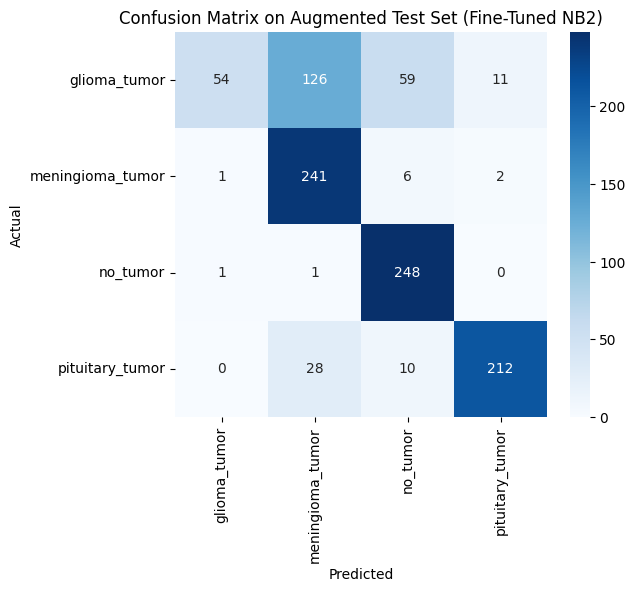

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on augmented test set
test_loss_NB2_aug, test_accuracy_NB2_aug, test_precision_NB2_aug, test_recall_NB2_aug = model.evaluate(
    X_test_augmented_NB2_resized, y_test_augmented_NB2_one_hot, verbose=1
)

print(f"\nNB2 Augmented Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_aug:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_aug:.4f}")
print(f" - Precision: {test_precision_NB2_aug:.4f}")
print(f" - Recall: {test_recall_NB2_aug:.4f}")

# Get predictions
y_pred_probs_NB2_aug = model.predict(X_test_augmented_NB2_resized)
y_pred_NB2_aug = np.argmax(y_pred_probs_NB2_aug, axis=1)  
y_true_NB2_aug = np.argmax(y_test_augmented_NB2_one_hot, axis=1)

# Classification report
print("\nNB2 Classification Report on Augmented Test Set:")
print(classification_report(y_true_NB2_aug, y_pred_NB2_aug, target_names=label_encoder.classes_))

# Confusion matrix
cm_NB2_aug = confusion_matrix(y_true_NB2_aug, y_pred_NB2_aug)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_NB2_aug, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Augmented Test Set (Fine-Tuned NB2)")
plt.show()


Key Observations
Slight Overall Performance Drop:

Accuracy fell slightly (0.78 → 0.76), indicating the model struggles with augmented variations.
The F1-score also dropped slightly (0.73 → 0.71), confirming some difficulty in adapting.
Glioma Tumor Classification Remains Poor:

Recall for glioma tumors is still extremely low (0.21 → 0.22).
Precision is high (0.96), meaning that when it predicts glioma, it's usually correct, but it rarely predicts glioma at all (low recall).
More Variability in Pituitary Tumor Predictions:

Recall for pituitary tumors dropped (0.92 → 0.85), showing sensitivity to augmentation.
No Tumor & Meningioma Tumor Predictions Are Stable:

The model still performs well on these classes, but there's a minor decrease in performance.
Conclusions
Fine-tuning did not generalize well to augmented variations, as performance slightly dropped.
Glioma tumor recall is still the biggest issue, suggesting the model fails to recognize gliomas under new conditions.
The model is slightly overconfident in its predictions—high precision but poor recall means it's playing "safe" rather than exploring uncertain predictions

 Experiment with Different Architectures
EfficientNetB0 might not be capturing glioma tumors well. A larger model (EfficientNetB2/B3) or a ResNet-based model might perform better.

Try EfficientNetB2

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall

# Define input layer (match dataset size)
input_layer = Input(shape=(150, 150, 3), name="input_layer")

# Load EfficientNetB2 WITH ImageNet weights
base_model_B2 = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Pass input manually
x = base_model_B2(input_layer)

# Freeze base model layers
base_model_B2.trainable = False  

# Add classification layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Create final model
model_NB2_B2 = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model_NB2_B2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Model summary
model_NB2_B2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 5, 5, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,437 (30.32 MB)

 Trainable params: 180,868 (706.52 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [47]:
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Create logs directory
log_dir_B2 = "./logs_NB2_B2"
os.makedirs(log_dir_B2, exist_ok=True)

# TensorBoard - Logs training details
tensorboard_callback_B2 = TensorBoard(log_dir=log_dir_B2, histogram_freq=1)

# ModelCheckpoint - Saves the best model
checkpoint_callback_B2 = ModelCheckpoint(
    filepath="best_model_NB2_B2.h5",  
    monitor="val_loss",  
    save_best_only=True,  
    verbose=1
)

# ReduceLROnPlateau - Adjusts learning rate when training stagnates
reduce_lr_callback_B2 = ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.1,  
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

# EarlyStopping - Stop training when no improvement
early_stopping_B2 = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Combine all callbacks
callbacks_NB2_B2 = [tensorboard_callback_B2, checkpoint_callback_B2, reduce_lr_callback_B2, early_stopping_B2]


In [48]:
history_NB2_B2 = model_NB2_B2.fit(
    X_train_NB2, y_train_NB2_one_hot,
    validation_data=(X_val_NB2, y_val_NB2_one_hot),
    batch_size=32,
    epochs=20,  # EarlyStopping will stop earlier if needed
    callbacks=callbacks_NB2_B2,  
    verbose=1
)



Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6680 - loss: 0.8442 - precision_3: 0.7162 - recall_3: 0.6034
Epoch 1: val_loss improved from inf to 0.34965, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.6684 - loss: 0.8435 - precision_3: 0.7165 - recall_3: 0.6039 - val_accuracy: 0.8714 - val_loss: 0.3497 - val_precision_3: 0.8880 - val_recall_3: 0.8469 - learning_rate: 0.0010
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8294 - loss: 0.4627 - precision_3: 0.8454 - recall_3: 0.8135
Epoch 2: val_loss improved from 0.34965 to 0.30555, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.8294 - loss: 0.4626 - precision_3: 0.8454 - recall_3: 0.8135 - val_accuracy: 0.8802 - val_loss: 0.3055 - val_precision_3: 0.8929 - val_recall_3: 0.8682 - learning_rate: 0.0010
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8564 - loss: 0.3773 - precision_3: 0.8689 - recall_3: 0.8441
Epoch 3: val_loss improved from 0.30555 to 0.24157, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.8564 - loss: 0.3772 - precision_3: 0.8689 - recall_3: 0.8441 - val_accuracy: 0.9078 - val_loss: 0.2416 - val_precision_3: 0.9202 - val_recall_3: 0.9005 - learning_rate: 0.0010
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8747 - loss: 0.3314 - precision_3: 0.8889 - recall_3: 0.8673
Epoch 4: val_loss improved from 0.24157 to 0.22024, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.8747 - loss: 0.3314 - precision_3: 0.8889 - recall_3: 0.8673 - val_accuracy: 0.9198 - val_loss: 0.2202 - val_precision_3: 0.9267 - val_recall_3: 0.9151 - learning_rate: 0.0010
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8853 - loss: 0.3012 - precision_3: 0.8990 - recall_3: 0.8751
Epoch 5: val_loss improved from 0.22024 to 0.20998, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.8853 - loss: 0.3012 - precision_3: 0.8990 - recall_3: 0.8751 - val_accuracy: 0.9286 - val_loss: 0.2100 - val_precision_3: 0.9346 - val_recall_3: 0.9229 - learning_rate: 0.0010
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8852 - loss: 0.2993 - precision_3: 0.8968 - recall_3: 0.8756
Epoch 6: val_loss improved from 0.20998 to 0.20170, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.8852 - loss: 0.2993 - precision_3: 0.8968 - recall_3: 0.8757 - val_accuracy: 0.9302 - val_loss: 0.2017 - val_precision_3: 0.9376 - val_recall_3: 0.9229 - learning_rate: 0.0010
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8997 - loss: 0.2851 - precision_3: 0.9074 - recall_3: 0.8898
Epoch 7: val_loss improved from 0.20170 to 0.19757, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.8997 - loss: 0.2851 - precision_3: 0.9074 - recall_3: 0.8898 - val_accuracy: 0.9276 - val_loss: 0.1976 - val_precision_3: 0.9362 - val_recall_3: 0.9250 - learning_rate: 0.0010
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8993 - loss: 0.2759 - precision_3: 0.9068 - recall_3: 0.8923
Epoch 8: val_loss did not improve from 0.19757
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.8993 - loss: 0.2759 - precision_3: 0.9068 - recall_3: 0.8923 - val_accuracy: 0.9318 - val_loss: 0.2041 - val_precision_3: 0.9352 - val_recall_3: 0.9250 - learning_rate: 0.0010
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9011 - loss: 0.2625 - precision_3: 0.9079 - recall_3: 0.8936
Epoch 9: val_loss improved from 0.19757 to 0.18259, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.9011 - loss: 0.2625 - precision_3: 0.9079 - recall_3: 0.8936 - val_accuracy: 0.9344 - val_loss: 0.1826 - val_precision_3: 0.9422 - val_recall_3: 0.9344 - learning_rate: 0.0010
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9083 - loss: 0.2444 - precision_3: 0.9177 - recall_3: 0.9031
Epoch 10: val_loss did not improve from 0.18259
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9083 - loss: 0.2444 - precision_3: 0.9177 - recall_3: 0.9031 - val_accuracy: 0.9349 - val_loss: 0.1892 - val_precision_3: 0.9361 - val_recall_3: 0.9302 - learning_rate: 0.0010
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9083 - loss: 0.2348 - precision_3: 0.9126 - recall_3: 0.9017
Epoch 11: val_loss improved from 0.18259 to 0.16867, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.9083 - loss: 0.2349 - precision_3: 0.9126 - recall_3: 0.9017 - val_accuracy: 0.9385 - val_loss: 0.1687 - val_precision_3: 0.9438 - val_recall_3: 0.9365 - learning_rate: 0.0010
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9065 - loss: 0.2549 - precision_3: 0.9141 - recall_3: 0.8987
Epoch 12: val_loss did not improve from 0.16867
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.9065 - loss: 0.2549 - precision_3: 0.9141 - recall_3: 0.8987 - val_accuracy: 0.9370 - val_loss: 0.1774 - val_precision_3: 0.9417 - val_recall_3: 0.9333 - learning_rate: 0.0010
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8986 - loss: 0.2627 - precision_3: 0.9058 - recall_3: 0.8931
Epoch 13: val_loss did not improve from 0.16867
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.8986 - loss: 0.2627 - precision_3: 0.9058 - recall_3: 0.8932 - val_accuracy: 0.9344 - val_loss: 0.1780 - val_precision_3

240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9197 - loss: 0.2137 - precision_3: 0.9260 - recall_3: 0.9151 - val_accuracy: 0.9474 - val_loss: 0.1571 - val_precision_3: 0.9532 - val_recall_3: 0.9438 - learning_rate: 1.0000e-04
Epoch 16/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9204 - loss: 0.2174 - precision_3: 0.9263 - recall_3: 0.9145
Epoch 16: val_loss improved from 0.15711 to 0.15657, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9204 - loss: 0.2174 - precision_3: 0.9263 - recall_3: 0.9145 - val_accuracy: 0.9464 - val_loss: 0.1566 - val_precision_3: 0.9517 - val_recall_3: 0.9443 - learning_rate: 1.0000e-04
Epoch 17/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9178 - loss: 0.2212 - precision_3: 0.9220 - recall_3: 0.9126
Epoch 17: val_loss improved from 0.15657 to 0.15579, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9178 - loss: 0.2211 - precision_3: 0.9220 - recall_3: 0.9126 - val_accuracy: 0.9469 - val_loss: 0.1558 - val_precision_3: 0.9527 - val_recall_3: 0.9443 - learning_rate: 1.0000e-04
Epoch 18/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9223 - loss: 0.2062 - precision_3: 0.9279 - recall_3: 0.9153
Epoch 18: val_loss improved from 0.15579 to 0.15441, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9223 - loss: 0.2062 - precision_3: 0.9279 - recall_3: 0.9153 - val_accuracy: 0.9484 - val_loss: 0.1544 - val_precision_3: 0.9548 - val_recall_3: 0.9469 - learning_rate: 1.0000e-04
Epoch 19/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9206 - loss: 0.2134 - precision_3: 0.9251 - recall_3: 0.9142
Epoch 19: val_loss improved from 0.15441 to 0.15280, saving model to best_model_NB2_B2.h5


240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.9205 - loss: 0.2134 - precision_3: 0.9251 - recall_3: 0.9142 - val_accuracy: 0.9495 - val_loss: 0.1528 - val_precision_3: 0.9539 - val_recall_3: 0.9474 - learning_rate: 1.0000e-04
Epoch 20/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9196 - loss: 0.2105 - precision_3: 0.9243 - recall_3: 0.9154
Epoch 20: val_loss did not improve from 0.15280
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.9196 - loss: 0.2105 - precision_3: 0.9243 - recall_3: 0.9154 - val_accuracy: 0.9484 - val_loss: 0.1536 - val_precision_3: 0.9533 - val_recall_3: 0.9453 - learning_rate: 1.0000e-04


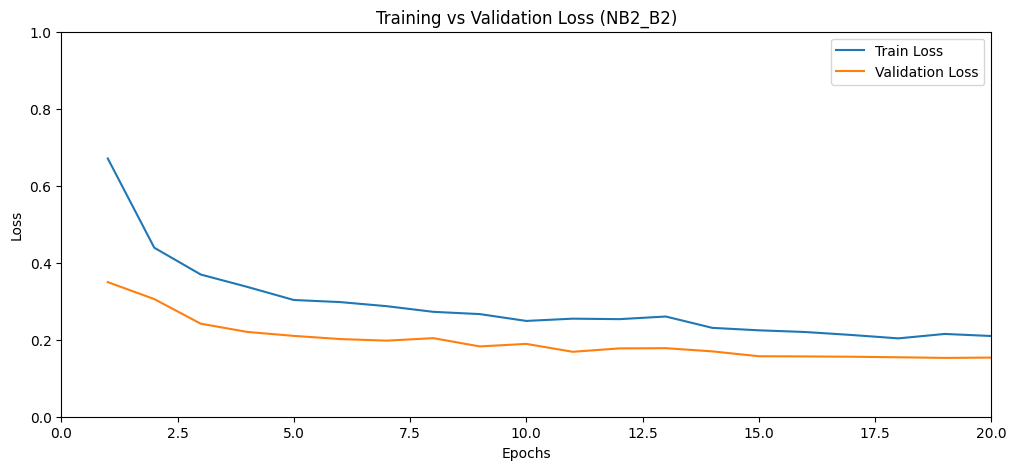

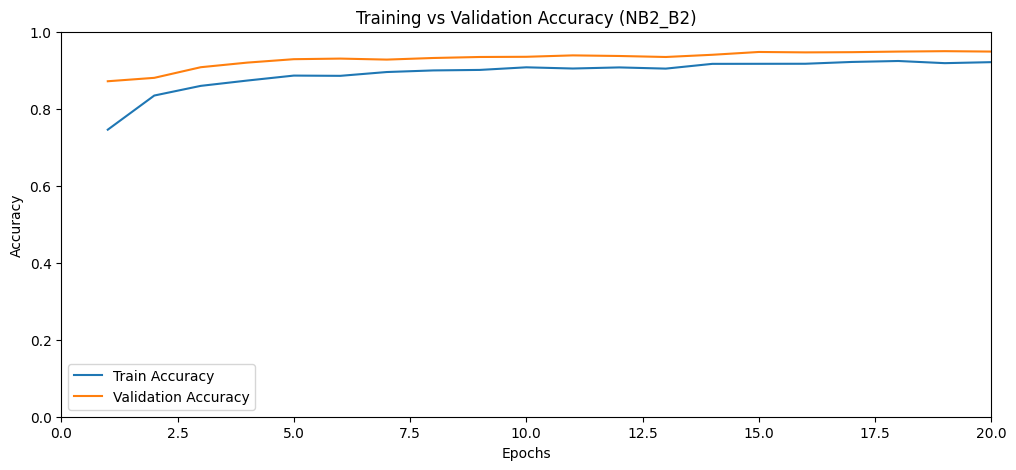

In [49]:
epochs = range(1, len(history_NB2_B2.history["loss"]) + 1)

# Plot Loss with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2_B2.history["loss"], label="Train Loss")
plt.plot(epochs, history_NB2_B2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (NB2_B2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()

# Plot Accuracy with both axes starting from 0
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_NB2_B2.history["accuracy"], label="Train Accuracy")
plt.plot(epochs, history_NB2_B2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (NB2_B2)")
plt.xlim(0, max(epochs))  # Ensure x-axis starts from 0
plt.ylim(0, 1)            # Ensure y-axis starts from 0
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 873ms/step - accuracy: 0.6063 - loss: 1.8206 - precision_3: 0.6090 - recall_3: 0.5905

NB2_B2 Test Set Evaluation:
 - Loss: 1.0525
 - Accuracy: 0.7741
 - Precision: 0.7844
 - Recall: 0.7665
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step

Classification Report (Fine-Tuned NB2_B2 Model on Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.93      0.28      0.43       100
meningioma_tumor       0.69      0.97      0.81       115
        no_tumor       0.78      1.00      0.88       105
 pituitary_tumor       0.91      0.81      0.86        74

        accuracy                           0.77       394
       macro avg       0.83      0.77      0.74       394
    weighted avg       0.82      0.77      0.74       394



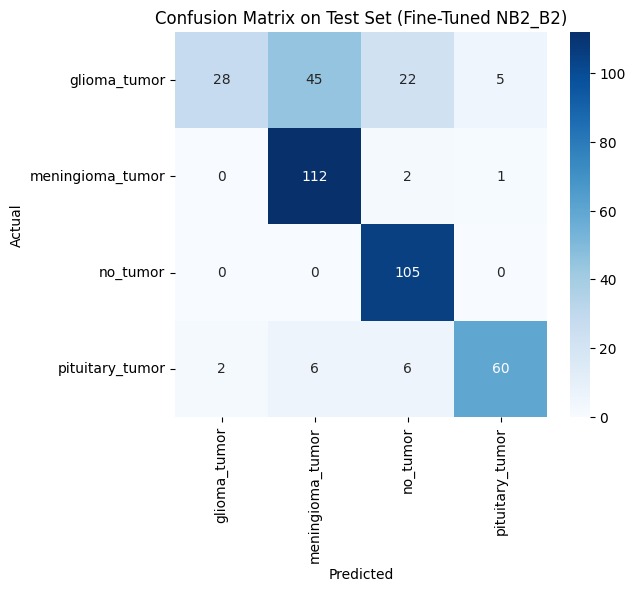

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on the original test set
test_loss_NB2_B2, test_accuracy_NB2_B2, test_precision_NB2_B2, test_recall_NB2_B2 = model_NB2_B2.evaluate(X_test_NB2_resized, y_test_NB2_one_hot, verbose=1)

print("\nNB2_B2 Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_B2:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_B2:.4f}")
print(f" - Precision: {test_precision_NB2_B2:.4f}")
print(f" - Recall: {test_recall_NB2_B2:.4f}")

# Get predictions from the fine-tuned NB2_B2 model on the original test dataset
pred_finetune_NB2_B2_test = model_NB2_B2.predict(X_test_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_B2_test = np.argmax(pred_finetune_NB2_B2_test, axis=1)

# Use y_test_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_B2_test = np.argmax(y_test_NB2_one_hot, axis=1)

# Print classification report
print("\nClassification Report (Fine-Tuned NB2_B2 Model on Test Set):")
print(classification_report(y_true_labels_finetune_NB2_B2_test, pred_labels_finetune_NB2_B2_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_B2_test = confusion_matrix(y_true_labels_finetune_NB2_B2_test, pred_labels_finetune_NB2_B2_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_B2_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set (Fine-Tuned NB2_B2)")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.5633 - loss: 1.9960 - precision_3: 0.5729 - recall_3: 0.5524

NB2_B2 Augmented Test Set Evaluation:
 - Loss: 1.0552
 - Accuracy: 0.7530
 - Precision: 0.7675
 - Recall: 0.7460
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

Classification Report (Fine-Tuned NB2_B2 Model on Augmented Test Set):
                  precision    recall  f1-score   support

    glioma_tumor       0.85      0.28      0.42       250
meningioma_tumor       0.62      0.91      0.74       250
        no_tumor       0.76      0.99      0.86       250
 pituitary_tumor       0.92      0.84      0.88       250

        accuracy                           0.75      1000
       macro avg       0.79      0.75      0.72      1000
    weighted avg       0.79      0.75      0.72      1000



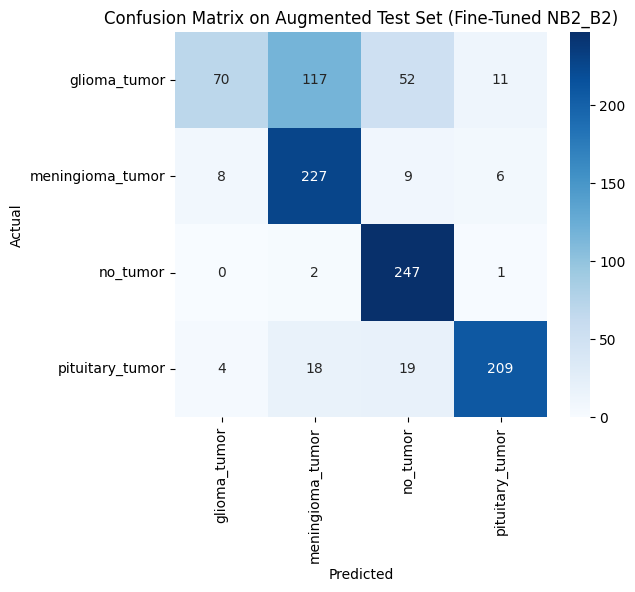

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model on augmented test set
test_loss_NB2_B2_aug, test_accuracy_NB2_B2_aug, test_precision_NB2_B2_aug, test_recall_NB2_B2_aug = model_NB2_B2.evaluate(X_test_augmented_NB2_resized, y_test_augmented_NB2_one_hot, verbose=1)

print("\nNB2_B2 Augmented Test Set Evaluation:")
print(f" - Loss: {test_loss_NB2_B2_aug:.4f}")
print(f" - Accuracy: {test_accuracy_NB2_B2_aug:.4f}")
print(f" - Precision: {test_precision_NB2_B2_aug:.4f}")
print(f" - Recall: {test_recall_NB2_B2_aug:.4f}")

# Get predictions
pred_finetune_NB2_B2_aug_test = model_NB2_B2.predict(X_test_augmented_NB2_resized)

# Convert predictions from probabilities to class labels
pred_labels_finetune_NB2_B2_aug_test = np.argmax(pred_finetune_NB2_B2_aug_test, axis=1)

# Use y_test_augmented_NB2_one_hot for evaluation
y_true_labels_finetune_NB2_B2_aug_test = np.argmax(y_test_augmented_NB2_one_hot, axis=1)

# Print classification report
print("\nClassification Report (Fine-Tuned NB2_B2 Model on Augmented Test Set):")
print(classification_report(y_true_labels_finetune_NB2_B2_aug_test, pred_labels_finetune_NB2_B2_aug_test, target_names=label_encoder.classes_))

# Confusion matrix
cm_finetune_NB2_B2_aug_test = confusion_matrix(y_true_labels_finetune_NB2_B2_aug_test, pred_labels_finetune_NB2_B2_aug_test)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_finetune_NB2_B2_aug_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Augmented Test Set (Fine-Tuned NB2_B2)")
plt.show()


Comparison of Model Performance Between NB2 (EfficientNetB0) and NB2_B2 (EfficientNetB2)
1. Overall Performance Improvement
Metric	NB2 (EfficientNetB0) - Test Set	NB2_B2 (EfficientNetB2) - Test Set	NB2 (EfficientNetB0) - Augmented Test Set	NB2_B2 (EfficientNetB2) - Augmented Test Set
Accuracy	60.63%	77.41%	56.33%	75.30%
Loss	1.8206	1.0525	1.9960	1.0552
Precision	60.90%	78.44%	57.29%	76.75%
Recall	59.05%	76.65%	55.24%	74.60%
Significant accuracy improvement from 60.63% to 77.41% on the test set.
Lower loss suggests the model is making more confident predictions.
Precision & Recall improved across all sets, meaning fewer misclassifications.

Conclusions
Switching to EfficientNetB2 improved overall model performance.

Better accuracy (+16-19%) and lower loss suggest that B2 extracts better features than B0.
General improvement in precision & recall across most categories.
Glioma Tumor Recall Remains the Biggest Problem

The model still struggles to identify glioma tumors correctly.
Even though EfficientNetB2 is better than B0, it still fails to generalize glioma features well.
Augmented Test Set Shows the Same Trends

Performance is consistent between original and augmented test sets.
EfficientNetB2 performs better than B0 on both datasets, meaning it's a real improvement and not overfitting.
